Here I'm making a better non-parametric tree of only a subset of sequences from the bigger v2g5 tree.
The aim is to get a better resolution on the disctiotion between JOX, ANS and FLS clades.
This distinction holds up in the bigger parametric tree methods reproducibly, although not all nodes of interest have sufficient bootstrap support.
With a non-parametric method, I aim to get a better idea of how reliable these nodes are.

**data**

I'm working with a subset of sequences of the JOX, ANS and FLS clades, retrieved from the v1g3 and the v2g5 trees. These subsets are redundant so they should be deduplicated first.

**approach**
I'll get the sequences from previous allignments, build a mafft tree, trim, attampt prank indelrealignment with a iqtree guide-tree, and then build a non-parametric tree with 200 bootstrap runs.

# compile data

deduplicate the subset list:

In [39]:
sort data/v2g5_subset-ids.txt | uniq | tr ' ' _ > data/temp.txt
mv data/temp.txt data/v2g5_subset-ids.txt

(phylo_ans) 

: 1

Make a fasta from this subset list

In [40]:
grep -f data/v2g5_subset-ids.txt \
     -A 1 \
    --no-group-sep \
     data/orthogroup_AtLDOX_AT4g22880_selection-v2_guide-v5.fasta \
> data/v2g5_JOX-ANS-FLS-subset.fasta

(phylo_ans) 004l

: 1

## align with mafft

Now align this subset of data:

In [41]:
inseq=v2g5_JOX-ANS-FLS-subset

(phylo_ans) 

: 1

In [42]:
rm "./data/alignments_raw/$inseq"_aligned-mafft*
if    [ ! -d ./data/alignments_raw/ ]
then  mkdir  ./data/alignments_raw
fi
prefix=data/alignments_raw/"$inseq"_aligned-mafft-einsi
if    [ ! -f "$prefix".fasta ]
then  einsi --thread $(nproc) data/$inseq.fasta \
            >  "$prefix".fasta \
            2> "$prefix".log
fi

(phylo_ans) 

: 1

Make a snapshot:

In [43]:
prefix=data/alignments_raw/"$inseq"_aligned-mafft-einsi
jalview -nodisplay \
        -open $prefix.fasta \
        -colour CLUSTAL \
        -png  $prefix.png > /dev/null 2> /dev/null

(phylo_ans) 

: 1

In [44]:
echo $prefix.png

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.png
(phylo_ans) 

: 1

which looks like this:
![](data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.png)

This looks like a good alignment to me, with minor column trimming I will be very happy and I doubt that indel realignment is even necessary like this 

## trimming

In [45]:
ls data/alignments_raw/$inseq*.fasta

data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.fasta
(phylo_ans) 

: 1

In [52]:
if    [ ! -d data/alignments_trimmed ]
then  mkdir  data/alignments_trimmed 
fi
trimappendix='trim-gt1'

for a in "data/alignments_raw/$inseq"_aligned*.fasta
do  appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
    if    [ ! -f data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta ]
    then  echo "trimming alignment $a"
          sed -i 's/ /_/g' $a
          trimal -in $a   \
                 -out data/alignments_trimmed/"$inseq"_"$appendix"_"$trimappendix".fasta \
                 -gt .1 2> /dev/null &
    fi
done

trimming alignment data/alignments_raw/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi.fasta
[1] 664134
(phylo_ans) 

: 1

In [49]:
for   i in data/alignments_trimmed/$inseq*.fasta
do    prefix=$(echo $i | sed 's/\.fasta//')
      if    [ ! 
      -f $prefix.png ]
      then  jalview -nodisplay \
                    -open $prefix.fasta \
                    -colour CLUSTAL \
                    -png  $prefix.png > /dev/null 2> /dev/null &
      fi
done
wait


[1] 663905?2004l
[2] 663910
[1]-  Done                    jalview -nodisplay -open $prefix.fasta -colour CLUSTAL -png $prefix.png > /dev/null 2> /dev/null
[2]+  Done                    jalview -nodisplay -open $prefix.fasta -colour CLUSTAL -png $prefix.png > /dev/null 2> /dev/null
(phylo_ans) 

: 1

In [ ]:
ls data/alignments_trimmed/$inseq*.png

#### gt1
![](data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1.png)
### gt4
![](data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.png)


I'll create a guide tree out of the gt4 version, and then try to get some extra indel info out of the alignment.
It won't be much, but the gt1 version gives me the impression there might be something to gain here.

## guide tree with iqtree

In [50]:
ls data/alignments_trimmed/$inseq*.fasta

data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt1.fasta
data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.fasta
(phylo_ans) 

: 1

In [37]:
a=data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.fasta
echo "making a iqtree fast tree of file $a"
appendix=$(echo $a | cut -d '/' -f 3- | sed "s/$inseq\_//" | sed "s/.fasta//")
echo $appendix
if   [ ! -d   analyses/"$inseq"_fasttrees/"$appendix" ]
then mkdir -p analyses/"$inseq"_fasttrees/"$appendix"
fi

iqprefix=analyses/"$inseq"_fasttrees/"$appendix"/"$inseq"_"$appendix"_iqtree-fast
if   [ ! -f "$iqprefix".iqtree ]
then nice iqtree -s $a -fast \
                 -m 'LG+R7' \
                 -nt AUTO \
                 -ntmax $(nproc)  \
                 -pre "$iqprefix" \
                 > "$iqprefix".stdout \
                 2> "$iqprefix".stderr &
else echo 'tree exists'
fi


making a iqtree fast tree of file data/alignments_trimmed/v2g5_JOX-ANS-FLS-subset_aligned-mafft-einsi_trim-gt4.fasta
aligned-mafft-einsi_trim-gt4
[1] 662897hylo_ans) 
(phylo_ans) 

: 1

Looking at the tree, I realise I should have included an algal outgroup like I normally do. 
Just to confidently place the root amongst some weirdly placed sequences.
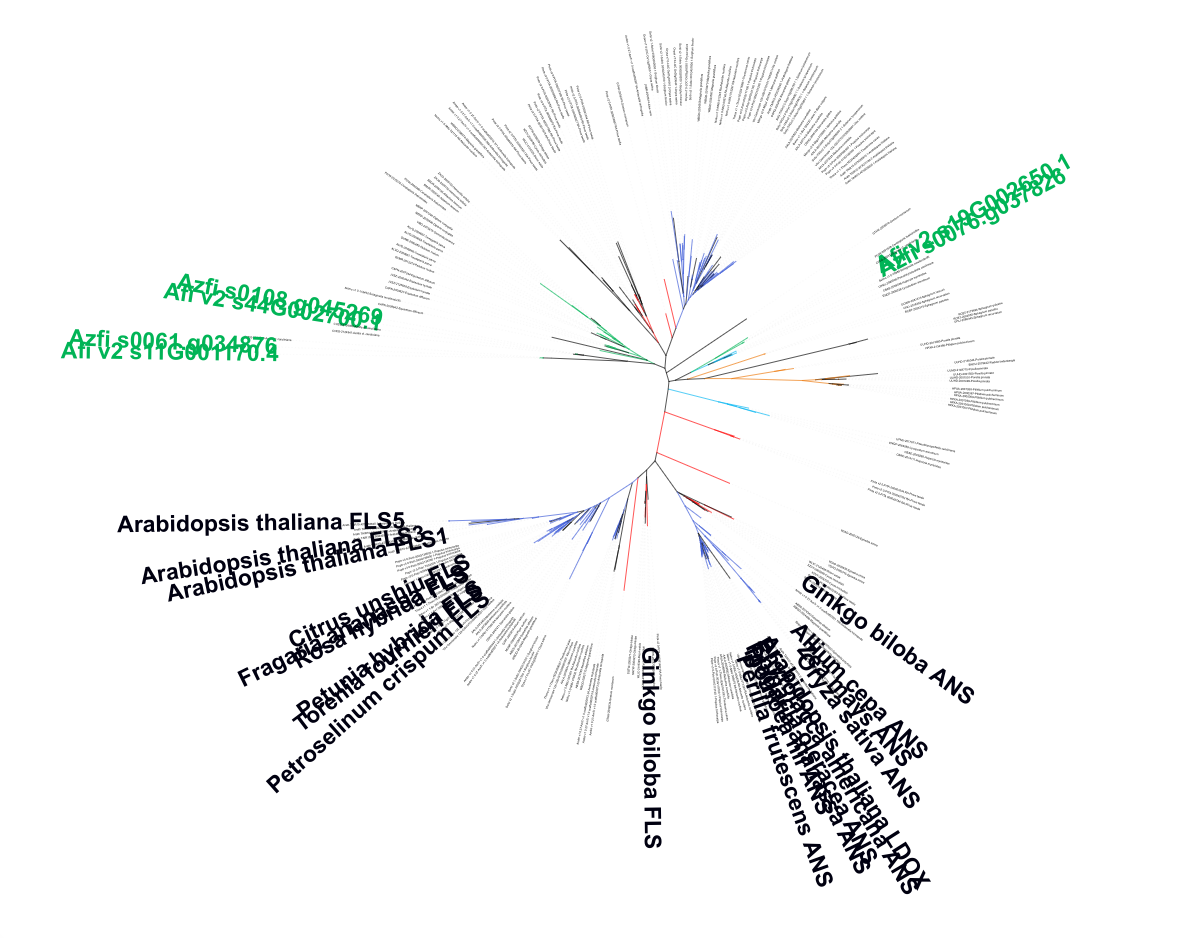